<a href="https://colab.research.google.com/github/KarnakarreddyAsireddy/Deep-dreams/blob/master/Deep_dreams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file('paris.jpg', 'https://i.imgur.com/aGBdQyK.jpg')
result_prefix = 'sky_dream'

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    'mixed4': 1.0,
    'mixed5': 1.5,
    'mixed6': 2.0,
    'mixed7': 2.5,
}


step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20  
max_loss=15

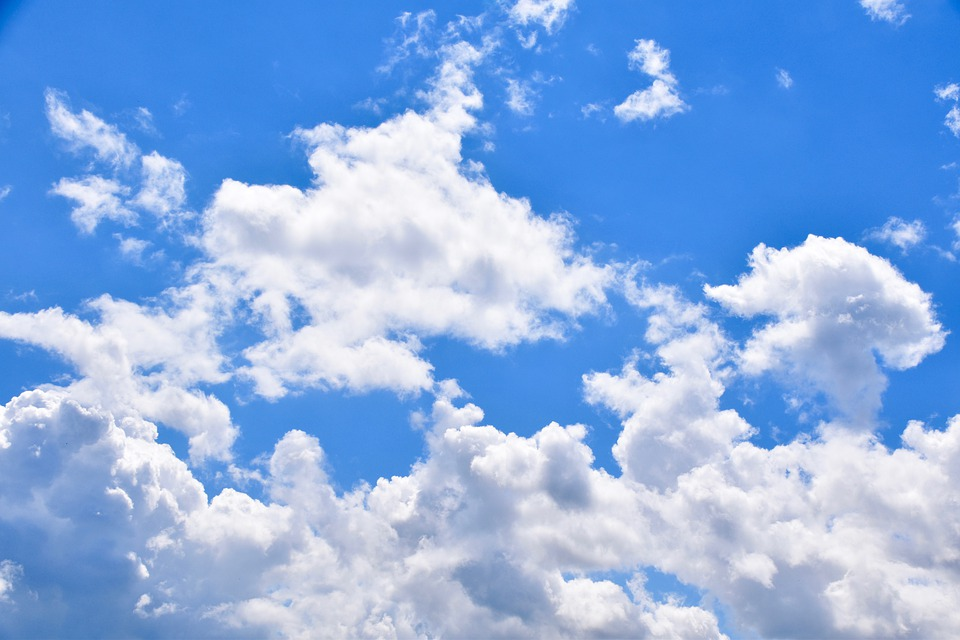

In [14]:
from IPython.display import Image, display
display(Image(base_image_path))

In [0]:
def preprocess_image(image_path):
    
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):   
    x = x.reshape((x.shape[1], x.shape[2], 3))  
    x /= 2.
    x += 0.5
    x *= 255.  
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
outputs_dict = dict([(layer.name, layer.output)
                     for layer in [model.get_layer(name)
                                   for name in layer_settings.keys()]])
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

In [0]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]    
    scaling = tf.reduce_prod(tf.cast(tf.shape(activation), 'float32'))
    loss += coeff * tf.reduce_sum(tf.square(activation[:, 2: -2, 2: -2, :])) / scaling
  return loss

In [0]:
@tf.function
def gradient_ascent_step(img, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img)
  # Compute gradients.
  grads = tape.gradient(loss, img)
  # Normalize gradients.
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += learning_rate * grads
  return loss, img

In [0]:
def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, img = gradient_ascent_step(img, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print('... Loss value at step %d: %.2f' % (i, loss))
  return img

In [20]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
  print('Processing octave %d with shape %s' % (i, shape))
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(img,
                             iterations=iterations,
                             learning_rate=step,
                             max_loss=max_loss)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img

  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + '.png', deprocess_image(img.numpy()))

Processing octave 0 with shape (326, 489)
... Loss value at step 0: 0.44
... Loss value at step 1: 0.62
... Loss value at step 2: 0.90
... Loss value at step 3: 1.24
... Loss value at step 4: 1.56
... Loss value at step 5: 1.91
... Loss value at step 6: 2.22
... Loss value at step 7: 2.50
... Loss value at step 8: 2.84
... Loss value at step 9: 3.09
... Loss value at step 10: 3.35
... Loss value at step 11: 3.63
... Loss value at step 12: 3.91
... Loss value at step 13: 4.15
... Loss value at step 14: 4.40
... Loss value at step 15: 4.65
... Loss value at step 16: 4.91
... Loss value at step 17: 5.16
... Loss value at step 18: 5.42
... Loss value at step 19: 5.64
Processing octave 1 with shape (457, 685)
... Loss value at step 0: 1.09
... Loss value at step 1: 1.74
... Loss value at step 2: 2.30
... Loss value at step 3: 2.76
... Loss value at step 4: 3.20
... Loss value at step 5: 3.58
... Loss value at step 6: 4.00
... Loss value at step 7: 4.37
... Loss value at step 8: 4.71
... Los

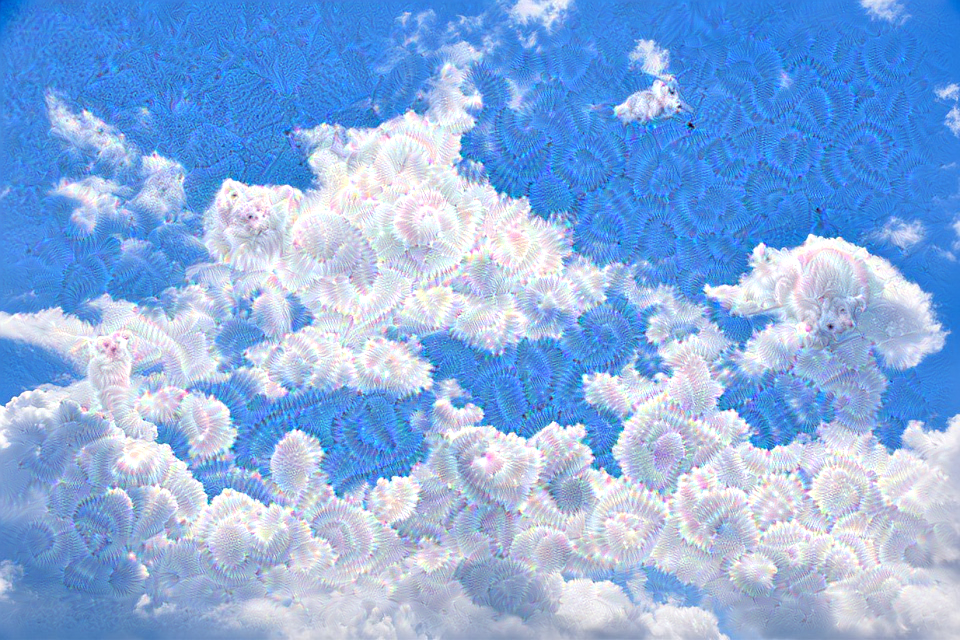

In [21]:
display(Image(result_prefix + '.png'))